# PyMC3 for Normal distributions

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import matplotlib.pyplot as plt

from pathlib import Path
import warnings

warnings.simplefilter('ignore', FutureWarning)
pd.plotting.register_matplotlib_converters()

In [2]:
try:
    import regime_switching
    root_path = Path(regime_switching.__root__).parent
except ImportError:
    root_path = Path(".").absolute().parent.parent

img_path = root_path / "latex" / "img" / "gen"

In [3]:
RANDOM_SEED = 99

## Generate data

In [4]:
rng = np.random.default_rng(RANDOM_SEED)

# Parameters
T = 40
mu_true = np.array([10, -5])
sigma_true = np.array([[9, -2], [-2, 4]])

n = len(mu_true)

# X = rng.normal(mu_true, sigma_true, size=T)
X = rng.multivariate_normal(mu_true, sigma_true, size=T).T
X.shape

(2, 40)

## Get Maximum Likelihood Estimates (MLE)

In [5]:
mu_mle = np.mean(X, axis=-1)
sigma_mle = ((X-mu_mle[:, np.newaxis]) @ (X-mu_mle[:, np.newaxis]).T) / (T-1)  
# sigma_mle = np.std(X, axis=-1, ddof=1) ** 2, sigma_mle
mu_mle, sigma_mle

(array([10.21766261, -4.54552729]),
 array([[ 7.76046339, -2.34898787],
        [-2.34898787,  3.24777438]]))

## Bayesian model via Probabilistic programming

In [6]:
# Note: Using pretty symbols for the graph
# μΣ

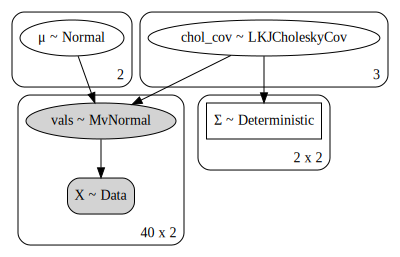

In [7]:
with pm.Model() as m:
    pm.Data('X', X.T)
    
    pm.Normal('μ', mu=0, sigma=100, shape=[n])

    sd_dist = pm.HalfCauchy.dist(beta=10)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=n, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(n, packed_chol, lower=True)
    
    pm.Deterministic("Σ", tt.dot(chol, chol.T))
    pm.MvNormal('vals', mu=m['μ'], chol=chol, shape=[n], observed=m['X'])
    
model_graph = pm.model_to_graphviz(m)

# Save image to disk
model_graph.render(img_path / "pp_mvn_graph", format="png", cleanup=True);

display(model_graph)

In [8]:
with m:
    # prior = pm.sample_prior_predictive(1000)
    posterior = pm.sample(
        draws=1000, tune=2000, random_seed=RANDOM_SEED, chains=2, cores=2
    )
    # ppc = pm.sample_posterior_predictive(posterior)
    ifd = az.from_pymc3(
        trace=posterior,
        coords={"OBS": np.arange(T), "COMPONENT": np.arange(n), "COMP_AUX": np.arange(n)},
        dims={
            "X": ["OBS", "COMPONENT"],
            "vals": ["OBS", "COMPONENT"],
            "μ": ["COMPONENT"],
            "Σ": ["COMPONENT", "COMP_AUX"],
        },
        log_likelihood=False,  #
    )    
ifd

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chol_cov, μ]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [01:48<00:00, 55.17draws/s] 


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [9]:
ifd.posterior

<xarray.Dataset>
Dimensions:         (COMPONENT: 2, COMP_AUX: 2, chain: 2, chol_cov_dim_0: 3, draw: 1000)
Coordinates:
  * chain           (chain) int64 0 1
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * COMPONENT       (COMPONENT) int64 0 1
  * chol_cov_dim_0  (chol_cov_dim_0) int64 0 1 2
  * COMP_AUX        (COMP_AUX) int64 0 1
Data variables:
    μ               (chain, draw, COMPONENT) float64 10.37 -4.076 ... -4.807
    chol_cov        (chain, draw, chol_cov_dim_0) float64 2.944 -0.486 ... 1.598
    Σ               (chain, draw, COMPONENT, COMP_AUX) float64 8.665 ... 3.268
Attributes:
    created_at:                 2020-06-05T14:45:26.270837
    arviz_version:              0.8.3
    inference_library:          pymc3
    inference_library_version:  3.8

## Plot trace

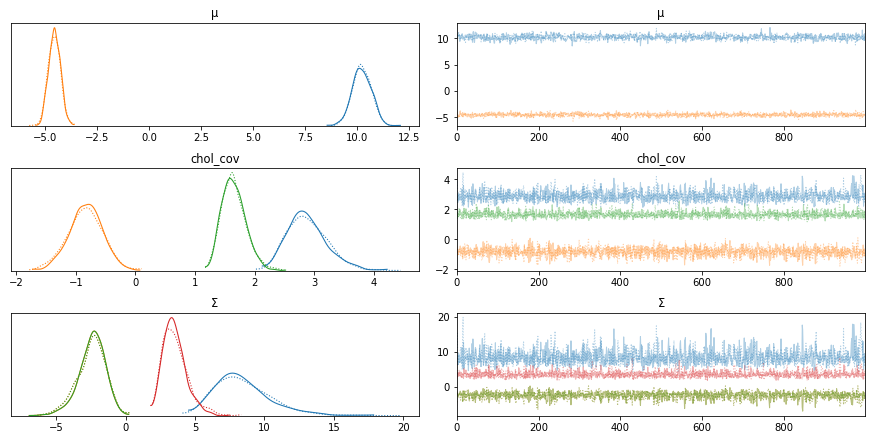

In [10]:
axs = az.plot_trace(ifd, compact=True)
fig = axs[0, 0].figure

# fig.tight_layout()
fig.savefig(img_path / "pp_mvn_trace.png");

## Plot results

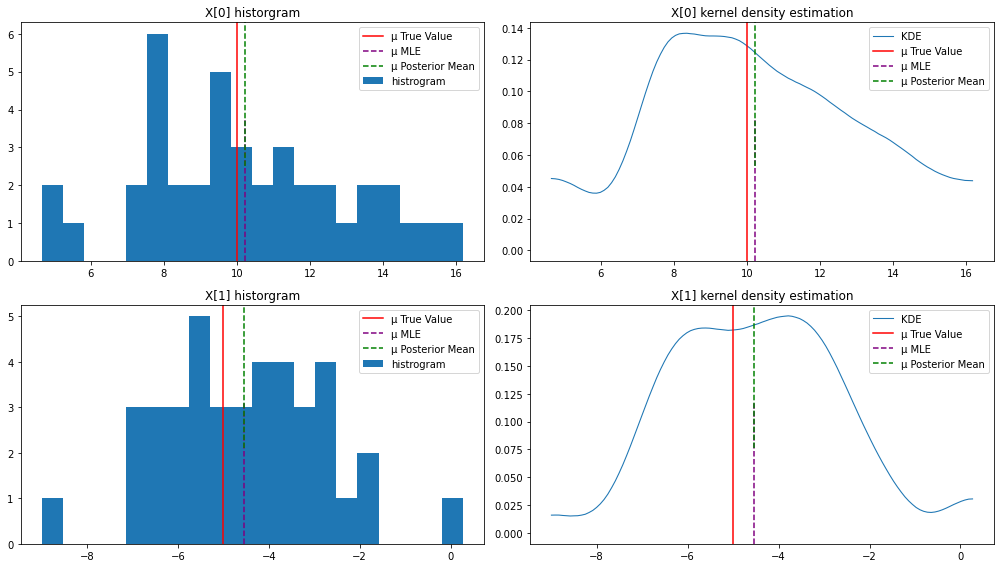

In [11]:
fig, axs = plt.subplots(n, 2, figsize=(14, 4 * n), squeeze=False)
for i in range(n):
    p_mu = ifd.posterior["μ"].sel(COMPONENT=i)
    ax = axs[i][0]
    ax.hist(X[i], bins=20, label="histrogram")
    ax.axvline(mu_true[i], color="red", linestyle="-", label="μ True Value")
    ax.axvline(mu_mle[i], 0, 0.6, color="purple", linestyle="--", label="μ MLE")
    ax.axvline(
        p_mu.mean(dim=["chain", "draw"]),
        0.4, 1,
        color="green",
        linestyle="--",
        label="μ Posterior Mean",
    )
    ax.legend()
    ax.set_title(f"X[{i}] historgram")

    ax = axs[i][1]
    az.plot_dist(X[i], ax=ax, textsize=10, label="KDE")
    ax.axvline(mu_true[i], color="red", linestyle="-", label="μ True Value")
    ax.axvline(mu_mle[i], 0, 0.6, color="purple", linestyle="--", label="μ MLE")
    ax.axvline(
        p_mu.mean(dim=["chain", "draw"]),
        0.4, 1,
        color="green",
        linestyle="--",
        label="μ Posterior Mean",
    )
    ax.legend()
    ax.set_title(f"X[{i}] kernel density estimation")

# Save to disk
fig.tight_layout()
fig.savefig(img_path / "pp_mvn_mu_comparison.png");

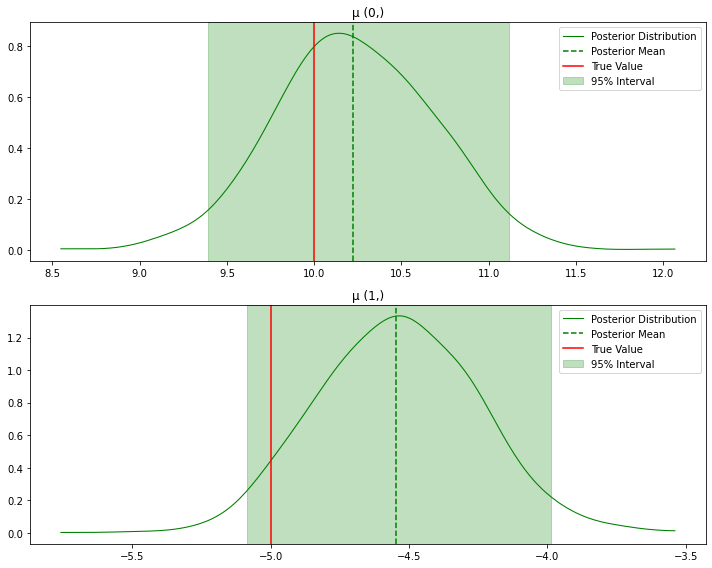

In [12]:
fig, axs = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)
for i in range(n):
    ax = axs[i][0]
    mu_i = ifd.posterior["μ"].sel(COMPONENT=i)
    az.plot_dist(
        mu_i, ax=ax, textsize=10, label="Posterior Distribution", color="green"
    )
    ax.axvline(
        mu_i.mean(dim=["chain", "draw"]),
        color="green",
        linestyle="--",
        label="Posterior Mean",
    )
    ax.axvspan(
        *az.hdi(mu_i, hdi_prob=0.95)["μ"].values,
        color="green",
        alpha=0.25,
        label="95% Interval",
    )
    ax.axvline(mu_true[i], color="red", linestyle="-", label="True Value")
    ax.legend()
    ax.set_title(f"μ ({i},)")
    
# Save to disk
fig.tight_layout()
fig.savefig(img_path / "pp_mvn_mu_hdi.png");

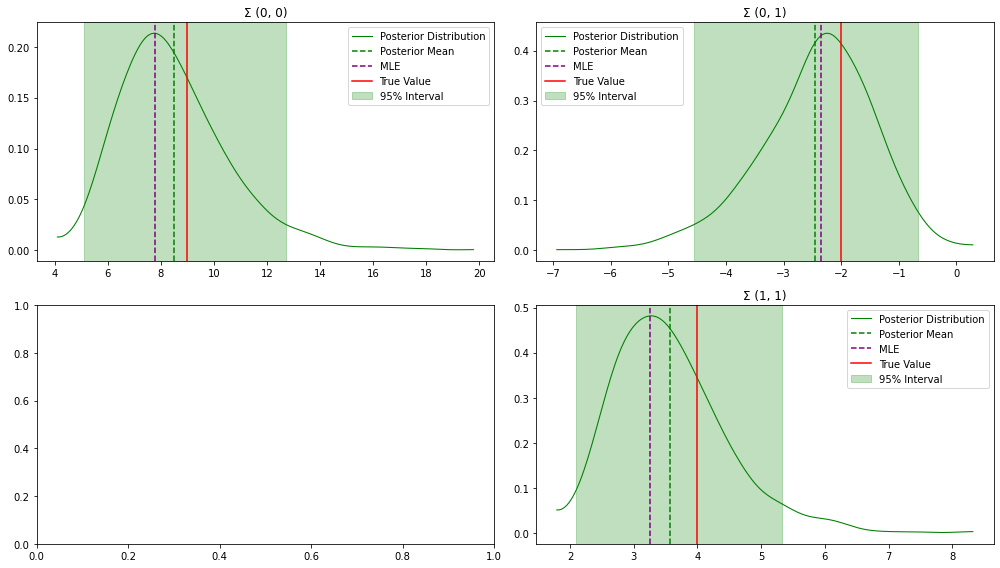

In [13]:
fig, axs = plt.subplots(n, n, figsize=(7 * n, 4 * n), squeeze=False)
for i in range(n):
    for j in range(n):
        if j < i:
            continue
        ax = axs[i][j]
        sigma_ij = ifd.posterior["Σ"].sel(COMPONENT=i, COMP_AUX=j)
        az.plot_dist(
            sigma_ij, ax=ax, textsize=10, label="Posterior Distribution", color="green"
        )
        ax.axvline(
            sigma_ij.mean(dim=["chain", "draw"]),
            color="green",
            linestyle="--",
            label="Posterior Mean",
        )
        ax.axvspan(
            *az.hdi(sigma_ij, hdi_prob=0.95)["Σ"].values,
            color="green",
            alpha=0.25,
            label="95% Interval",
        )
        ax.axvline(sigma_mle[i, j], 0, 1, color="purple", linestyle="--", label="MLE")
        ax.axvline(sigma_true[i, j], color="red", linestyle="-", label="True Value")
        ax.legend()
        ax.set_title(f"Σ ({i}, {j})")
        
# Save to disk
fig.tight_layout()
fig.savefig(img_path / "pp_mvn_sigma_hdi.png");